In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.linalg import svd
from functions import *
from get_estimated_covariance import *
import scipy.stats
from scipy.interpolate import UnivariateSpline
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [72]:
n = 200
r1 = 200
r2 = 200
N = 100
t = np.linspace(0,1,N)
#sds1 = np.append(np.array([1.5,0.5,0.1,0.05]), np.abs(np.random.normal(0,0.001,r1-4))).reshape(r1,1)
sds1 = np.append(np.array([1,1,0.001]), 1/(np.arange(30,r1+27)**2)).reshape(r1,1)
sds1 = np.sqrt(sds1)
#sds2 = sds1 * np.random.chisquare(1000,sds1.shape)/1000
sds2 = np.append(np.array([0.001,0.001,1]), 1/(np.arange(30,r2+27)**2)).reshape(r2,1)
sds2 = np.sqrt(sds2)

In [120]:
def mu1(t):
    return np.zeros(t.shape)
    #return np.exp(t)/100
def mu2(t):
    #return np.sin(2*np.pi*t)/10
    #return -np.log(t + 1)/100
    return 1 + np.zeros_like(t)

def g1(x,n):
    if n == 0:
        return np.array([1]* len(x))
    else:
        return np.sqrt(2)*np.cos(2* n * np.pi * x)

In [121]:
def g2(x,n):
    if n == 0:
        return np.array([1]* len(x))
    else:
        return np.sqrt(2)*np.sin(2* n * np.pi * x)

In [122]:
def g1(x,n):
    if n == 0:
        return np.array([1]* len(x))
    else:
        return np.sqrt(2)*np.cos(2* n * np.pi * x)

In [123]:
def g2(x,n):
    return g1(x,n)
    if n == 0:
        return np.array([1]* len(x))
    else:
        return np.sqrt(2)*np.sin(2* n * np.pi * x)

def g1(x,n):
    uu = np.zeros(n+1)
    uu[-1] = 1
    aa = np.polynomial.legendre.Legendre(uu)
    return np.sqrt(N) * aa(2*x-1)/np.linalg.norm(aa(2*x-1))

def g2(x,n):
    if n == 0:
        return scipy.stats.norm.pdf(x, loc = 0.5, scale = 0.6)
    elif n == 1:
        return scipy.stats.norm.pdf(x, loc = 0.2, scale = 0.25)
    elif n == 2:
        return scipy.stats.norm.pdf(x, loc = 0.8, scale = 0.2)
    else:
        return scipy.stats.norm.pdf(x, loc = np.random.rand(1), scale = np.random.uniform(1,100))

In [124]:
def X1(t,rv):
    return np.sum(np.multiply(np.repeat(rv,N).reshape(r1,N),np.array([g1(t,i) for i in range(r1)])),axis = 0)

In [125]:
def X2(t,rv):
    return np.sum(np.multiply(np.repeat(rv,N).reshape(r2,N),np.array([g2(t,i) for i in range(r2)])),axis = 0)

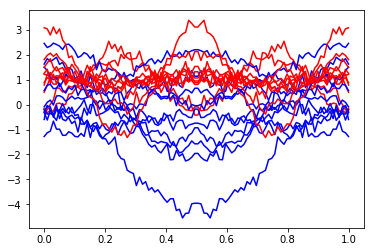

In [126]:
plt.figure()
for i in range(10):
    plt.plot(t,generate_data(10, r1, t, X1, mu1, sds1)[i],'b')
    plt.plot(t,generate_data(10, r2, t, X2, mu2, sds2)[i],'r')
plt.show()

In [127]:
realK1 = get_real_cov(sds1,N,g1,t)
realK2 = get_real_cov(sds2,N,g2,t)

In [128]:
data1 = generate_data(n, r1, t, X1, mu1, sds1)
data2 = generate_data(n, r2, t, X2, mu2, sds2)

In [129]:
from mpl_toolkits.mplot3d import Axes3D

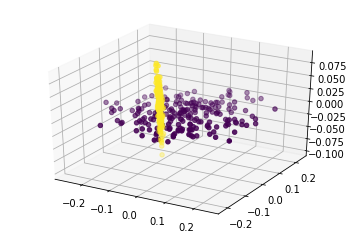

In [130]:
K1 = np.cov(data1, rowvar=False, bias=True)
blar = np.linalg.svd(K1)[0]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xs = np.append(data1 @ blar[:,0]/100, data2 @ blar[:,0]/100)
ys = np.append(data1 @ blar[:,1]/100, data2 @ blar[:,1]/100)
zs = np.append(data1 @ blar[:,2]/100, data2 @ blar[:,2]/100)

ax.scatter(xs, ys, zs, c=np.append(np.zeros(n),np.ones(n))+1)

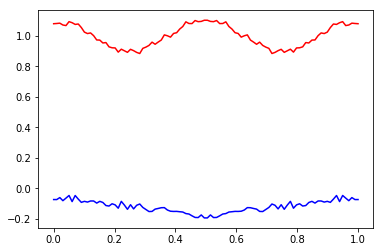

In [131]:
import seaborn as sns
plt.figure()
plt.plot(t,data1.mean(0),'b')
plt.plot(t,data2.mean(0),'r')

The relative error is 0.0475475101536, 0.083083784798


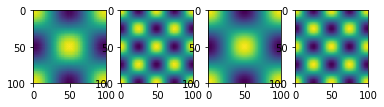

In [132]:
plt.figure()

K1 = np.cov(data1, rowvar=False, bias=True)
plt.subplot(1, 4, 1)
plt.imshow(K1)

K2 = np.cov(data2, rowvar=False, bias=True)
plt.subplot(1, 4, 2)
plt.imshow(K2)

plt.subplot(1, 4, 3)
plt.imshow(realK1)

plt.subplot(1, 4, 4)
plt.imshow(realK2)

score1 = np.linalg.norm(realK1-K1)/np.linalg.norm(realK1)
score2 = np.linalg.norm(realK2-K2)/np.linalg.norm(realK2)

print('The relative error is ' + str(score1) + ', ' + str(score2))

In [133]:
def test(Y,cov1,cov2,d1,d2):
    N = len(d1)
    svd1 = np.linalg.svd(cov1)
    svd2 = np.linalg.svd(cov2)
    r=min(np.count_nonzero(svd1[1]),np.count_nonzero(svd2[1]))
    est_rv1 = (1/np.sqrt(svd1[1][:r])) * ((Y-d1).reshape((1,-1)) @ svd1[0][:,:r])[-1]
    est_rv1 = est_rv1/N
    est_rv2 = (1/np.sqrt(svd2[1][:r])) * ((Y-d2).reshape((1,-1)) @ svd2[0][:,:r])[-1]
    est_rv2 = est_rv2/N
    t1 = np.sum(np.log(svd1[1][:r])) + np.sum(est_rv1**2) 
    t2 = np.sum(np.log(svd2[1][:r])) + np.sum(est_rv2**2)
    return t1 - t2

In [134]:
def test2(Y,cov1,cov2,d1,d2):
    N = len(d1)
    svd1 = np.linalg.svd(cov1)
    svd2 = np.linalg.svd(cov2)
    r=min(np.count_nonzero(svd1[1]),np.count_nonzero(svd2[1]))
    est_rv1 = (1/np.sqrt(svd1[1][:r])) * ((Y-d1).reshape((1,-1)) @ svd1[0][:,:r])[-1]
    est_rv1 = est_rv1/N
    est_rv2 = (1/np.sqrt(svd2[1][:r])) * ((Y-d2).reshape((1,-1)) @ svd2[0][:,:r])[-1]
    est_rv2 = est_rv2/N
    t1 = np.sum(np.log(svd1[1][:r])) + (Y-d1).reshape((1,-1)) @ np.linalg.pinv(K1) @ (Y-d1).reshape((-1,1))
    t2 = np.sum(np.log(svd2[1][:r])) + (Y-d2).reshape((1,-1)) @ np.linalg.pinv(K2) @ (Y-d2).reshape((-1,1))
    return t1 - t2

In [135]:
train_results = np.zeros((1,2))
for i in range(n):
    qw,er = test2(data1[i],K1,K2,data1.mean(0),data2.mean(0)), test2(data2[i],K1,K2,data1.mean(0),data2.mean(0))
    train_results = np.r_[train_results, np.array([qw,er]).reshape((1,2))]
train_results = train_results[1:]

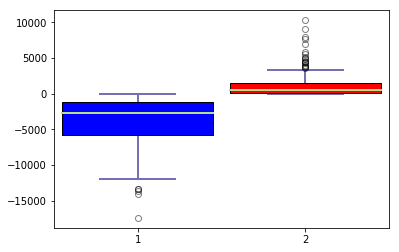

In [136]:
plt.figure()
get_boxplots(train_results)

In [137]:
np.mean(train_results[:,0]>0),np.mean(train_results[:,1]<0)

(0.0, 0.0)

res = np.zeros((1,2))
for rr in range(1,21):
    ii = np.linalg.svd(K1)
    er1 = ii[1][:rr]*ii[0][:,:rr]@ ii[0][:,:rr].T
    ii = np.linalg.svd(K2)
    er2 = ii[1][:rr]*ii[0][:,:rr]@ ii[0][:,:rr].T
    train_results = np.zeros((1,2))
    for i in range(n):
        qw,er = test(data1[i],er1,er2,data1.mean(0),data2.mean(0)), test(data2[i],er1,er2,data1.mean(0),data2.mean(0))
        train_results = np.r_[train_results, np.array([qw,er]).reshape((1,2))]
    train_results = train_results[1:]
    res = np.r_[res,np.array([np.mean(train_results[:,0]>0),np.mean(train_results[:,1]<0)]).reshape((1,2))]

plt.plot(np.arange(1,21),1-res[:,0],'b')
plt.plot(np.arange(1,21),1-res[:,1],'r')
plt.ylim(-0.1,1.1)
plt.savefig('accu-rank')

In [138]:
train_results.mean(0)

array([-3807.43251735,  1207.43772018])

In [139]:
test_results = np.zeros((1,2))
newdata1 = np.zeros((1,N))
newdata2 = np.zeros((1,N))
for _ in range(1000):
    newX1 = generate_data(1,r1,t,X1,mu1,sds1).ravel()
    newX2 = generate_data(1,r2,t,X2,mu2,sds2).ravel()
    newdata1 = np.r_[newdata1, newX1.reshape((1,N))]
    newdata2 = np.r_[newdata2, newX2.reshape((1,N))]
    test_results = np.r_[test_results,np.array([test2(newX1,K1,K2,data1.mean(0),data2.mean(0)),\
                                                test2(newX2,K1,K2,data1.mean(0),data2.mean(0))]).reshape((1,2))]
test_results = test_results[1:]
newdata1 = newdata1[1:]
newdata2 = newdata2[1:]

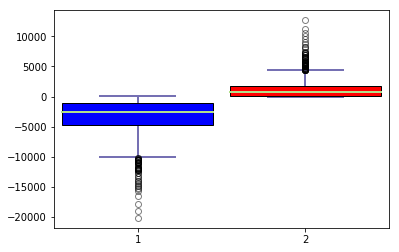

In [140]:
get_boxplots(test_results)

In [141]:
np.mean(test_results[:,0]>0),np.mean(test_results[:,1]<0)

(0.0040000000000000001, 0.0070000000000000001)

In [142]:
test_results.mean(0)

array([-3433.55179861,  1327.86034525])

In [41]:
delta = 0.9
bounds1, bounds21 = get_eff_bounds(delta=delta, N=N, n=n)
bounds2, bounds22 = get_eff_bounds(delta=delta, N=N, n=n)

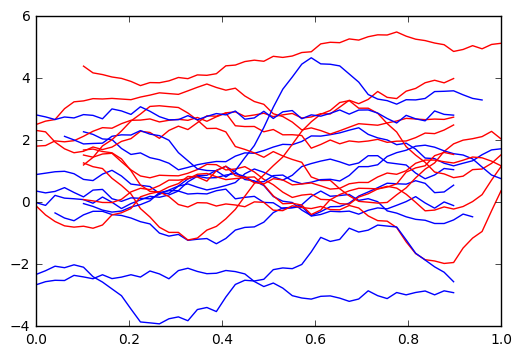

In [42]:
for i in range(10):
    ss,ee = bounds1[i]
    plt.plot(t[ss:ee],data1[i,ss:ee],'b')
    ss,ee = bounds2[i]
    plt.plot(t[ss:ee],data2[i,ss:ee],'r')
plt.savefig('fragex')

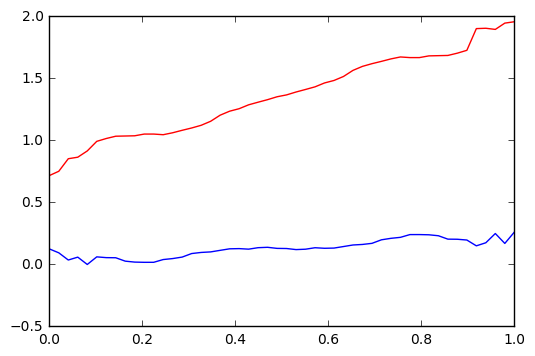

In [43]:
estmu1 = np.array([hmu(data1,i,bounds1) for i in range(N)])
estmu2 = np.array([hmu(data2,i,bounds2) for i in range(N)])
plt.plot(t,estmu1,'b')
plt.plot(t,estmu2,'r')

In [44]:
trunc_cov1 = get_trunc_cov(data1,bounds21)
P1 = get_P(N,delta)
tmp1 = dog(4,P1,trunc_cov1)[1].reshape((N,-1))
est1 = tmp1 @ tmp1.T
trunc_cov2 = get_trunc_cov(data2,bounds22)
P2 = get_P(N,delta)
tmp2 = dog(4,P2,trunc_cov2)[1].reshape((N,-1))
est2 = tmp2 @ tmp2.T

0.114198088216 0.175840044407
The relative error w.r.t. the smoothed estimated is 0.128436102017, 0.174299556684


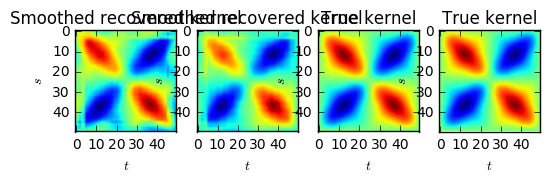

In [45]:
print(score1,score2)
#smooth_est1 = smooth_matrix(est1,t)
plt.subplot(1, 4, 1)
plt.imshow(est1)
plt.xlabel('$t$')
plt.ylabel('$s$')
plt.title('Smoothed recovered kernel')
#smooth_est2 = smooth_matrix(est2,t)
plt.subplot(1, 4, 2)
plt.imshow(est2)
plt.xlabel('$t$')
plt.ylabel('$s$')
plt.title('Smoothed recovered kernel')

plt.subplot(1, 4, 3)
plt.imshow(realK1)
plt.xlabel('$t$')
plt.ylabel('$s$')
plt.title('True kernel')

plt.subplot(1, 4, 4)
plt.imshow(realK2)
plt.xlabel('$t$')
plt.ylabel('$s$')
plt.title('True kernel')

score1 = np.linalg.norm(realK1-est1)/np.linalg.norm(realK1)
score2 = np.linalg.norm(realK2-est2)/np.linalg.norm(realK2)

print('The relative error w.r.t. the smoothed estimated is ' + str(score1) + ', ' + str(score2))

plt.subplot(3,2,1)
plt.imshow(realK1)
plt.title('$K_0$')
plt.subplot(3,2,2)
plt.imshow(realK2)
plt.title('$K_1$')
plt.subplot(3,2,3)
plt.imshow(K1)
plt.title('$\hat{K}_0$')
plt.subplot(3,2,4)
plt.imshow(K2)
plt.title('$\hat{K}_1$')
plt.subplot(3,2,5)
plt.imshow(est1)
plt.title('$\hat{K}_{0,f}$')
plt.subplot(3,2,6)
plt.imshow(est2)
plt.title('$\hat{K}_{1,f}$')
plt.tight_layout()
plt.savefig('covs')

In [46]:
train_results = np.zeros((1,2))
for i in range(n):
    start1, end1 = bounds1[i]
    start2, end2 = bounds2[i]
    cov11 = est1[start1:end1,start1:end1]
    cov12 = est1[start2:end2,start2:end2]
    cov21 = est2[start1:end1,start1:end1]
    cov22 = est2[start2:end2,start2:end2]
    bla1 = data1[i,start1:end1]
    bla2 = data2[i,start2:end2]
    qw,er = test(bla1,cov11,cov21,estmu1[start1:end1],estmu2[start1:end1]), test(bla2,cov12,cov22,estmu1[start2:end2],estmu2[start2:end2])
    train_results = np.r_[train_results, np.array([qw,er]).reshape((1,2))]
train_results = train_results[1:]

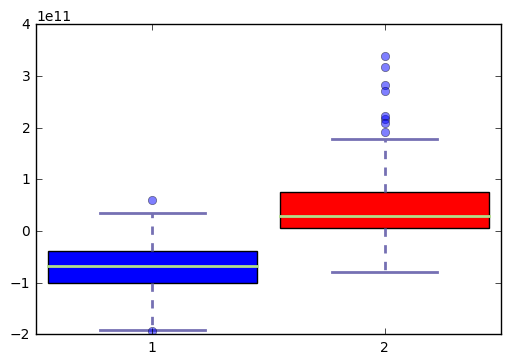

In [47]:
get_boxplots(train_results)

In [48]:
np.mean(train_results[:,0]>0),np.mean(train_results[:,1]<0)

(0.040000000000000001, 0.17499999999999999)

In [49]:
train_results.mean(0)

array([ -7.17438405e+10,   4.99606943e+10])

In [54]:
test_results = np.zeros((1,2))
newdata1 = np.zeros((1,N))
newdata2 = np.zeros((1,N))
for _ in range(1000):
    tz = get_eff_bounds(N,delta,1)[0].ravel()
    newX1 = generate_data(1,r1,t,X1,mu1,sds1).ravel()
    newX2 = generate_data(1,r2,t,X2,mu2,sds2).ravel()
    newdata1 = np.r_[newdata1, newX1.reshape((1,N))]
    newdata2 = np.r_[newdata2, newX2.reshape((1,N))]
    start, end = tz[0],tz[1]
    cov1 = est1[start:end,start:end]
    cov2 = est2[start:end,start:end]
    bla1 = newX1[start:end]
    bla2 = newX2[start:end]
    qw,er = test(bla1,cov1,cov2,estmu1[start:end],estmu2[start:end]),\
    test(bla2,cov1,cov2,estmu1[start:end],estmu2[start:end])
    
    
    test_results = np.r_[test_results,np.array([qw,er]).reshape((1,2))]
test_results = test_results[1:]
newdata1 = newdata1[1:]
newdata2 = newdata2[1:]

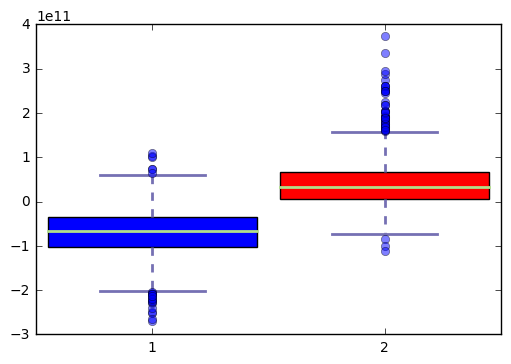

In [55]:
get_boxplots(test_results)

In [56]:
np.mean(test_results[:,0]>0),np.mean(test_results[:,1]<0)

(0.068000000000000005, 0.192)

In [57]:
test_results.mean(0)

array([ -7.06816948e+10,   4.32972718e+10])

ii = np.linalg.svd(est1)
oo = np.linalg.svd(K1)

print(ii[1]-oo[1])
for i in range(10):
    plt.plot(t,ii[0][:,i],'b')
    plt.plot(t,oo[0][:,i] + 1e-3,'r')
    plt.show()

plt.plot(np.log(ii[1]),'r')
plt.plot(np.log(oo[1]),'b')

rr = 10
plt.imshow(ii[1][:rr] * ii[0][:,:rr] @ ii[0][:,:rr].T)
plt.colorbar()
plt.show()
plt.imshow(oo[1][:rr] * oo[0][:,:rr] @ oo[0][:,:rr].T)
plt.colorbar()

plt.imshow(est1)

0.1
The relative error w.r.t. the smoothed estimated is 0.632899802654, 0.653532524445
train 0.4 0.525
test 0.435 0.53
0.1
The relative error w.r.t. the smoothed estimated is 0.93766078562, 0.819389993926
train 0.4 0.485
test 0.414 0.526
0.1
The relative error w.r.t. the smoothed estimated is 0.877843828186, 0.984545838567
train 0.305 0.49
test 0.393 0.554
0.1
The relative error w.r.t. the smoothed estimated is 1.06207995971, 0.841044233226
train 0.37 0.52
test 0.416 0.512
0.1
The relative error w.r.t. the smoothed estimated is 1.12371855365, 0.66592547644
train 0.45 0.44
test 0.518 0.429
0.2
The relative error w.r.t. the smoothed estimated is 0.62633752594, 0.925985283697
train 0.405 0.35
test 0.489 0.416
0.2
The relative error w.r.t. the smoothed estimated is 0.441006061937, 0.515509040205
train 0.35 0.39
test 0.408 0.48
0.2
The relative error w.r.t. the smoothed estimated is 0.54629228791, 0.649480392905
train 0.45 0.305
test 0.506 0.341
0.2
The relative error w.r.t. the smoothed es

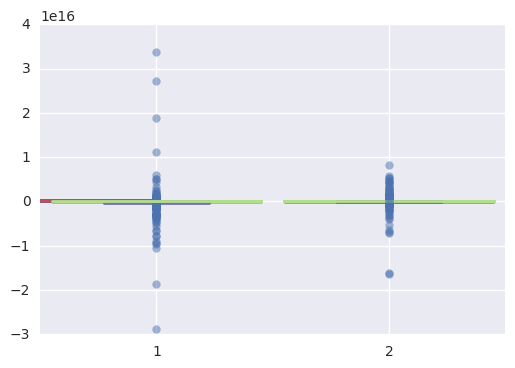

In [61]:
numit = 5

retr1 = np.zeros((numit,11))
retr2 = np.zeros((numit,11))
rete1 = np.zeros((numit,11))
rete2 = np.zeros((numit,11))
recov1 = np.zeros((numit,11))
recov2 = np.zeros((numit,11))

for dd in range(10): 
    delta = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1][dd]
    for ere in range(numit):
        data1 = generate_data(n, r1, t, X1, mu1, sds1)
        data2 = generate_data(n, r2, t, X2, mu2, sds2)
        print(delta)
        bounds1, bounds21 = get_eff_bounds(delta=delta, N=N, n=n)
        bounds2, bounds22 = get_eff_bounds(delta=delta, N=N, n=n)

        estmu1 = np.array([hmu(data1,i,bounds1) for i in range(N)])
        estmu2 = np.array([hmu(data2,i,bounds2) for i in range(N)])
        plt.plot(t,estmu1,'b')
        plt.plot(t,estmu2,'r')

        trunc_cov1 = get_trunc_cov(data1,bounds21)
        P1 = get_P(N,delta)
        tmp1 = dog(4,P1,trunc_cov1)[1].reshape((N,-1))
        est1 = tmp1 @ tmp1.T
        trunc_cov2 = get_trunc_cov(data2,bounds22)
        P2 = get_P(N,delta)
        tmp2 = dog(4,P2,trunc_cov2)[1].reshape((N,-1))
        est2 = tmp2 @ tmp2.T

       

        score1 = np.linalg.norm(realK1-est1)/np.linalg.norm(realK1)
        score2 = np.linalg.norm(realK2-est2)/np.linalg.norm(realK2)
        
        recov1[ere,dd] = score1
        recov2[ere,dd] = score2

        print('The relative error w.r.t. the smoothed estimated is ' + str(score1) + ', ' + str(score2))

        train_results = np.zeros((1,2))
        for i in range(n):
            start1, end1 = bounds1[i]
            start2, end2 = bounds2[i]
            cov11 = est1[start1:end1,start1:end1]
            cov12 = est1[start2:end2,start2:end2]
            cov21 = est2[start1:end1,start1:end1]
            cov22 = est2[start2:end2,start2:end2]
            bla1 = data1[i,start1:end1]
            bla2 = data2[i,start2:end2]
            qw,er = test(bla1,cov11,cov21,estmu1[start1:end1],estmu2[start1:end1]), test(bla2,cov12,cov22,estmu1[start2:end2],estmu2[start2:end2])
            train_results = np.r_[train_results, np.array([qw,er]).reshape((1,2))]
        train_results = train_results[1:]

        get_boxplots(train_results)

        print('train',np.mean(train_results[:,0]>0),np.mean(train_results[:,1]<0))
        retr1[ere,dd] = np.mean(train_results[:,0]>0)
        retr2[ere,dd] = np.mean(train_results[:,1]<0)


        train_results.mean(0)



        test_results = np.zeros((1,2))
        for _ in range(1000):
            tz = get_eff_bounds(N,delta,1)[0].ravel()
            newX1 = generate_data(1,r1,t,X1,mu1,sds1).ravel()
            newX2 = generate_data(1,r2,t,X2,mu2,sds2).ravel()
            start, end = tz[0],tz[1]
            cov1 = est1[start:end,start:end]
            cov2 = est2[start:end,start:end]
            bla1 = newX1[start:end]
            bla2 = newX2[start:end]
            qw,er = test(bla1,cov1,cov2,estmu1[start:end],estmu2[start:end]),\
            test(bla2,cov1,cov2,estmu1[start:end],estmu2[start:end])


            test_results = np.r_[test_results,np.array([qw,er]).reshape((1,2))]
        test_results = test_results[1:]

        print('test',np.mean(test_results[:,0]>0),np.mean(test_results[:,1]<0))
        
        rete1[ere,dd] = np.mean(test_results[:,0]>0)
        rete2[ere,dd] = np.mean(test_results[:,1]<0)

        test_results.mean(0)
for ere in range(numit):
    data1 = generate_data(n, r1, t, X1, mu1, sds1)
    data2 = generate_data(n, r2, t, X2, mu2, sds2)
    K1 = np.cov(data1, rowvar=False, bias=True)
    K2 = np.cov(data2, rowvar=False, bias=True)
    score1 = np.linalg.norm(realK1-K1)/np.linalg.norm(realK1)
    score2 = np.linalg.norm(realK2-K2)/np.linalg.norm(realK2)
    recov1[ere,10] = score1
    recov2[ere,10] = score2
    train_results = np.zeros((1,2))
    for i in range(n):
        qw,er = test(data1[i],K1,K2,data1.mean(0),data2.mean(0)), test(data2[i],K1,K2,data1.mean(0),data2.mean(0))
        train_results = np.r_[train_results, np.array([qw,er]).reshape((1,2))]
    train_results = train_results[1:]
    retr1[ere,10] = np.mean(train_results[:,0]>0)
    retr2[ere,10] = np.mean(train_results[:,1]<0)
    test_results = np.zeros((1,2))
    for _ in range(1000):
        newX1 = generate_data(1,r1,t,X1,mu1,sds1).ravel()
        newX2 = generate_data(1,r2,t,X2,mu2,sds2).ravel()
        test_results = np.r_[test_results,np.array([test(newX1,K1,K2,data1.mean(0),data2.mean(0)),\
                                                    test(newX2,K1,K2,data1.mean(0),data2.mean(0))]).reshape((1,2))]
    test_results = test_results[1:]
    rete1[ere,10] = np.mean(test_results[:,0]>0)
    rete2[ere,10] = np.mean(test_results[:,1]<0)

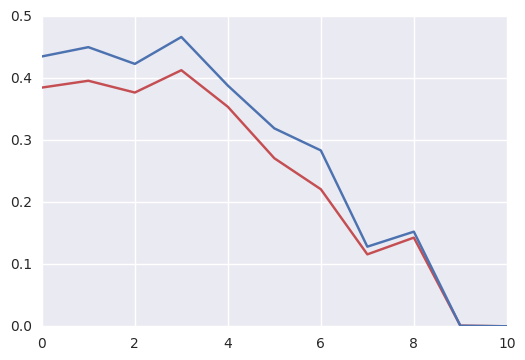

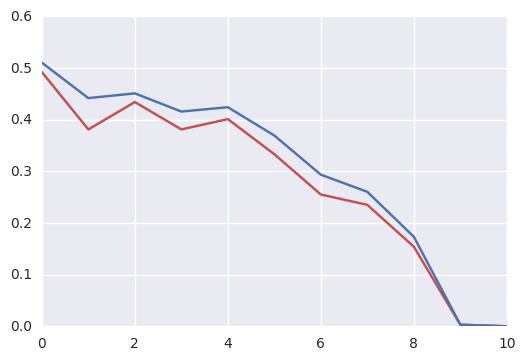

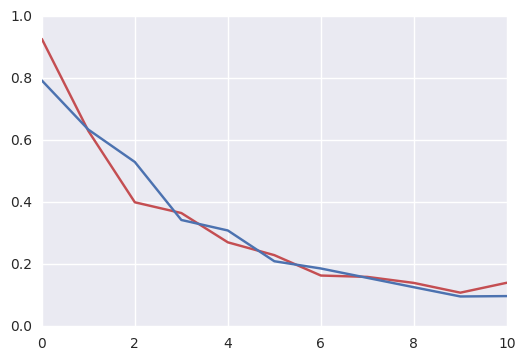

In [62]:
plt.plot(retr1.mean(0),'r')
plt.plot(rete1.mean(0),'b')
plt.show()
plt.plot(retr2.mean(0),'r')
plt.plot(rete2.mean(0),'b')
plt.show()
plt.plot(recov1.mean(0),'r')
plt.plot(recov2.mean(0),'b')
plt.show()

In [63]:
import seaborn as sns; sns.set(color_codes=True)

/home/william/anaconda3/lib/python3.5/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


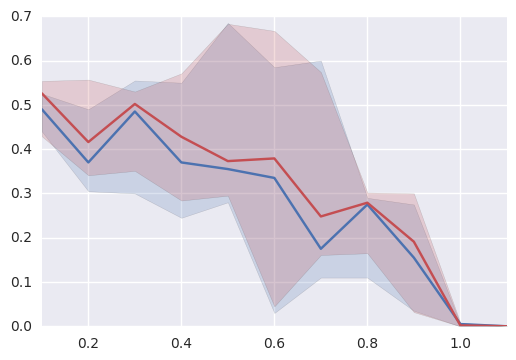

In [66]:
ax = sns.tsplot(data=retr2, time=np.linspace(0.1,1.1,11), ci=95,estimator=np.median)
ax = sns.tsplot(data=rete2, time=np.linspace(0.1,1.1,11), color='r',ci=95,estimator=np.median)

In [ ]:
from IPython.display import Audio
sound_file = 'http://www.wavsource.com/snds_2017-09-17_1751672946049674/animals/rooster.wav'

In [ ]:
Audio(url=sound_file, autoplay=True)